# Tutorial: Basics of Iterative Inference Programming in Gen

This tutorial introduces the basics of inference programming in Gen.
In particular, in this notebook we'll focus on _iterative_
inference programs, which include Markov chain Monte Carlo algorithms.

## The task: curve-fitting with outliers

Suppose we have a dataset of points in the $x,y$ plane that is _mostly_ explained by a linear relationship, but which also has several outliers. Our goal will be to automatically identify the outliers, and to find a linear relationship (a slope and intercept, as well as an inherent noise level) that explains rest of the points:

<img src="./images/example-inference.png" alt="See https://dspace.mit.edu/bitstream/handle/1721.1/119255/MIT-CSAIL-TR-2018-020.pdf, Figure 2(a))" width="600"/>

This is a simple inference problem. But it has two features that make it ideal for introducing  concepts in modeling and inference. 

1. First, we want not only to estimate the slope and intercept of the line that best fits the data, but also to classify each point as an inlier or outlier; that is, there are a large number of latent variables of interest, enough to make importance sampling an unreliable method (absent a more involved custom proposal that does the heavy lifting). 
2. Second, several of the parameters we're estimating (the slope and intercept) are continuous and amenable to gradient-based search techniques, which will allow us to explore Gen's optimization capabilities.

Let's get started!

## Outline

**Section 1.** [Writing the model: a first attempt](#writing-model)

**Section 2.** [Visualizing the model's behavior](#visualizing)

**Section 3.** [ The problem with generic importance sampling ](#importance)

**Section 4.** [MCMC Inference Part 1: Block Resimulation](#mcmc-1)

**Section 5.** [MCMC Inference Part 2: Gaussian Drift](#mcmc-2)

**Section 6.** [MCMC Inference Part 3: Proposals based on heuristics](#mcmc-3)

**Section 7.** [MAP Optimization](#map)

In [1]:
import Random, Logging
using Gen, Plots

# Disable logging, because @animate is verbose otherwise
Logging.disable_logging(Logging.Info);

## 1. Writing the model <a name="writing-model"></a>

We begin, as usual, by writing a model: a generative function responsible
(conceptually) for simulating a synthetic dataset.

Our model will take as input a vector of `x` coordinates, and produce as
output corresponding `y` coordinates. 

We will also use this opportunity to introduce some syntactic sugar.
As described in the previous notebook, random choices in Gen are given
_addresses_ using the syntax `{addr} ~ distribution(...)`. But this can
be a bit verbose, and often leads to code that looks like the following:

```julia
x = {:x} ~ normal(0, 1)
slope = {:slope} ~ normal(0, 1)
```

In these examples, the variable name is duplicated as the address of the
random choice. Because this is a common pattern, Gen provides syntactic
sugar that makes it nicer to use:

```julia
# Desugars to "x = {:x} ~ normal(0, 1)"
x ~ normal(0, 1)
# Desugars to "slope = {:slope} ~ normal(0, 1)"
slope ~ normal(0, 1)
```

Note that sometimes, it is still necessary to use the `{...}` form, for example
in loops:

```julia
# INVALID:
for i=1:10
    y ~ normal(0, 1) # The name :y will be used more than once!!
    println(y)
end

# VALID:
for i=1:10
    y = {(:y, i)} ~ normal(0, 1) # OK: the address is different each time.
    println(y)
end
```

We'll use this new syntax for writing our model of linear regression with
outliers. As we've seen before, the model generates parameters from a prior,
and then simulates data based on those parameters:

In [2]:
@gen function regression_with_outliers(xs::Vector{<:Real})
    # First, generate some parameters of the model. We make these
    # random choices, because later, we will want to infer them
    # from data. The distributions we use here express our assumptions
    # about the parameters: we think the slope and intercept won't be
    # too far from 0; that the noise is relatively small; and that
    # the proportion of the dataset that don't fit a linear relationship
    # (outliers) could be anything between 0 and 1.
    slope ~ normal(0, 2)
    intercept ~ normal(0, 2)
    noise ~ gamma(1, 1)
    prob_outlier ~ uniform(0, 1)
    
    # Next, we generate the actual y coordinates.
    n = length(xs)
    ys = Float64[]
    
    for i = 1:n
        # Decide whether this point is an outlier, and set
        # mean and standard deviation accordingly
        if ({:data => i => :is_outlier} ~ bernoulli(prob_outlier))
            (mu, std) = (0., 10.)
        else
            (mu, std) = (xs[i] * slope + intercept, noise)
        end
        # Sample a y value for this point
        push!(ys, {:data => i => :y} ~ normal(mu, std))
    end
    ys
end;

## 2. What our model is doing: visualizing the prior 

Let's visualize what our model is doing by drawing some samples from the
prior.

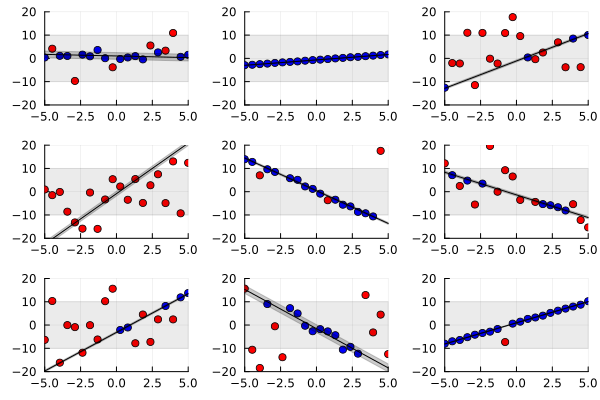

In [3]:
# Generate nine traces and visualize them
include("visualization/regression_viz.jl")
xs     = collect(range(-5, stop=5, length=20))
traces = [Gen.simulate(regression_with_outliers, (xs,)) for i in 1:9];
Plots.plot([visualize_trace(t) for t in traces]...)

##### Legend:

* red points: outliers;
* blue points: inliers (i.e. regular data);
* dark grey shading: noise associated with inliers; and
* light grey shading: noise associated with outliers.

Note that an outlier can occur anywhere — including close to the line — and
that our model is capable of generating datasets in which the vast majority
of points are outliers.

## 3. The problem with generic importance sampling  <a name="generic-importance"></a>

To motivate the need for more complex inference algorithms, let's begin by
using the simple importance sampling method from the previous tutorial, and
thinking about where it fails.

First, let us create a synthetic dataset to do inference _about_.

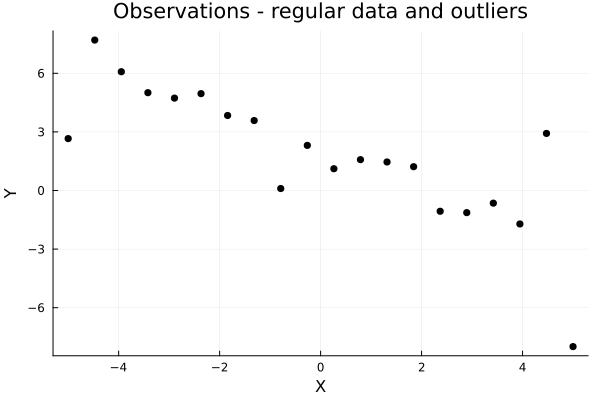

In [4]:
function make_synthetic_dataset(n)
    Random.seed!(1)
    prob_outlier = 0.2
    true_inlier_noise = 0.5
    true_outlier_noise = 5.0
    true_slope = -1
    true_intercept = 2
    xs = collect(range(-5, stop=5, length=n))
    ys = Float64[]
    for (i, x) in enumerate(xs)
        if rand() < prob_outlier
            y = randn() * true_outlier_noise
        else
            y = true_slope * x + true_intercept + randn() * true_inlier_noise
        end
        push!(ys, y)
    end
    (xs, ys)
end
    
(xs, ys) = make_synthetic_dataset(20);
Plots.scatter(xs, ys, color="black", xlabel="X", ylabel="Y", 
              label=nothing, title="Observations - regular data and outliers")

We will to express our _observations_ as a `ChoiceMap` that constrains the
values of certain random choices to equal their observed values. Here, we
want to constrain the values of the choices with address `:data => i => :y`
(that is, the sampled $y$ coordinates) to equal the observed $y$ values.
Let's write a helper function that takes in a vector of $y$ values and
creates a `ChoiceMap` that we can use to constrain our model:

In [13]:
function make_constraints(ys::Vector{Float64})
    constraints = Gen.choicemap()
    for i=1:length(ys)
        constraints[:data => i => :y] = ys[i]
    end
    constraints
end;

We can apply it to our dataset's vector of `ys` to make a set of constraints
for doing inference:

In [14]:
observations = make_constraints(ys);

Now, we use the library function `importance_resampling` to draw approximate
posterior samples given those observations:

In [15]:
function logmeanexp(scores)
    logsumexp(scores) - log(length(scores))
end;

Average log probability: -52.5798873932707


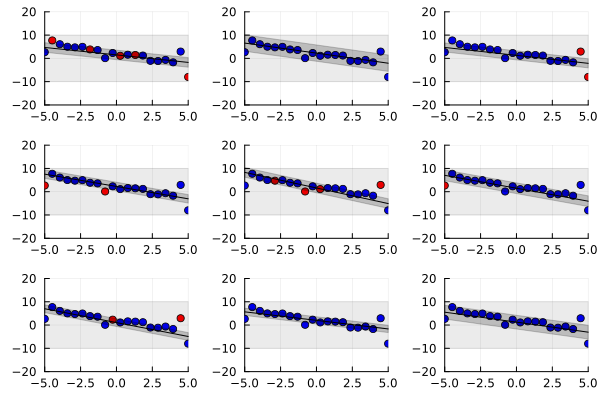

In [16]:
traces    = [first(Gen.importance_resampling(regression_with_outliers, (xs,), observations, 2000)) for i in 1:9]
log_probs = [get_score(t) for t in traces]
println("Average log probability: $(logmeanexp(log_probs))")
Plots.plot([visualize_trace(t) for t in traces]...)

We see here that importance resampling hasn't completely failed: it generally
finds a reasonable position for the line. But the details are off: there is
little logic to the outlier classification, and the inferred noise around the
line is too wide. The problem is that there are just too many variables to
get right, and so sampling everything in one go is highly unlikely to produce
a perfect hit.

In the remainder of this notebook, we'll explore techniques for finding the
right solution _iteratively_, beginning with an initial guess and making many
small changes, until we achieve a reasonable posterior sample.

## 4. MCMC Inference Part 1: Block Resimulation  <a name="mcmc-1"></a>

### What is MCMC?

_Markov Chain Monte Carlo_ ("MCMC") methods are a powerful family of
algorithms for iteratively producing approximate samples from a distribution
(when applied to Bayesian inference problems, the posterior distribution of
unknown (hidden) model variables given data).

There is a rich theory behind MCMC methods, but we focus on applying MCMC in
Gen and introducing theoretical ideas only when necessary for understanding.
As we will see, Gen provides abstractions that hide and automate much of the
math necessary for implementing MCMC algorithms correctly.

The general shape of an MCMC algorithm is as follows. We begin by sampling an
intial setting of all unobserved variables; in Gen, we produce an initial
_trace_ consistent with (but not necessarily _probable_ given) our
observations. Then, in a long-running loop, we make small, stochastic changes
to the trace; in order for the algorithm to be asymptotically correct, these
stochastic updates must satisfy certain probabilistic properties.

One common way of ensuring that the updates do satisfy those properties is to
compute a _Metropolis-Hastings acceptance ratio_. Essentially, after
proposing a change to a trace, we add an "accept or reject" step that
stochastically decides whether to commit the update or to revert it. This is
an over-simplification, but generally speaking, this step ensures we are more
likely to accept changes that make our trace fit the observed data better,
and to reject ones that make our current trace worse. The algorithm also
tries not to go down dead ends: it is more likely to take an exploratory step
into a low-probability region if it knows it can easily get back to where it
came from.

Gen's `metropolis_hastings` function _automatically_ adds this
"accept/reject" check (including the correct computation of the probability
of acceptance or rejection), so that inference programmers need only
think about what sorts of updates might be useful to propose. Starting in
this section, we'll look at several design patterns for MCMC updates, and how
to apply them in Gen.

### Block Resimulation

One of the simplest strategies we can use is called Resimulation MH, and it
works as follows.

We begin, as in most iterative inference algorithms, by sampling an initial
trace from our model, fixing the observed choices to their observed values.

```julia
# Gen's `generate` function accepts a model, a tuple of arguments to the model,
# and a `ChoiceMap` representing observations (or constraints to satisfy). It returns
# a complete trace consistent with the observations, and an importance weight.  
# In this call, we ignore the weight returned.
(tr, _) = generate(regression_with_outliers, (xs,), observations)
```

Then, in each iteration of our program, we propose changes to all our model's
variables in "blocks," by erasing a set of variables from our current trace
and _resimulating_ them from the model. After resimulating each block of
choices, we perform an accept/reject step, deciding whether the proposed
changes are worth making.

```julia
# Pseudocode
for iter=1:500
    tr = maybe_update_block_1(tr)
    tr = maybe_update_block_2(tr)
    ...
    tr = maybe_update_block_n(tr)
end
```

The main design choice in designing a Block Resimulation MH algorithm is how
to block the choices together for resimulation. At one extreme, we could put
each random choice the model makes in its own block. At the other, we could
put all variables into a single block (a strategy sometimes called
"independent" MH, and which bears a strong similarity to importance
resampling, as it involves repeatedly generating completely new traces and
deciding whether to keep them or not). Usually, the right thing to do is
somewhere in between.

For the regression problem, here is one possible blocking of choices:

**Block 1: `slope`, `intercept`, and `noise`.** These parameters determine
the linear relationship; resimulating them is like picking a new line. We
know from our importance sampling experiment above that before too long,
we're bound to sample something close to the right line.

**Blocks 2 through N+1: Each `is_outlier`, in its own block.** One problem we
saw with importance sampling in this problem was that it tried to sample
_every_ outlier classification at once, when in reality the chances of a
single sample that correctly classifies all the points are very low. Here, we
can choose to resimulate each `is_outlier` choice separately, and for each
one, decide whether to use the resimulated value or not.

**Block N+2: `prob_outlier`.** Finally, we can propose a new `prob_outlier`
value; in general, we can expect to accept the proposal when it is in line 
with the current hypothesized proportion of `is_outlier` choices that are 
set to `true`.

Resimulating a block of variables is the simplest form of update that Gen's
`metropolis_hastings` operator (or `mh` for short) supports. When supplied
with a _current trace_ and a _selection_ of trace addresses to resimulate,
`mh` performs the resimulation and the appropriate accept/reject check, then
returns a possibly updated trace, along with a boolean indicating whether the 
update was accepted or not. A selection is created using the `select`
method. So a single update of the scheme we proposed above would look like
this:

In [17]:
# Perform a single block resimulation update of a trace.
function block_resimulation_update(tr)
    # Block 1: Update the line's parameters
    line_params = select(:noise, :slope, :intercept)
    (tr, _) = mh(tr, line_params)
    
    # Blocks 2-N+1: Update the outlier classifications
    (xs,) = get_args(tr)
    n = length(xs)
    for i=1:n
        (tr, _) = mh(tr, select(:data => i => :is_outlier))
    end
    
    # Block N+2: Update the prob_outlier parameter
    (tr, _) = mh(tr, select(:prob_outlier))
    
    # Return the updated trace
    tr
end;

All that's left is to (a) obtain an initial trace, and then (b) run that
update in a loop for as long as we'd like:

In [18]:
function block_resimulation_inference(xs, ys, observations)
    observations = make_constraints(ys)
    (tr, _) = generate(regression_with_outliers, (xs,), observations)
    for iter=1:500
        tr = block_resimulation_update(tr)
    end
    tr
end;

Let's test it out:

In [19]:
scores = Vector{Float64}(undef, 10)
for i=1:10
    @time tr = block_resimulation_inference(xs, ys, observations)
    scores[i] = get_score(tr)
end
println("Log probability: ", logmeanexp(scores))

  0.960270 seconds (10.87 M allocations: 644.107 MiB, 7.67% gc time, 1.41% compilation time)
  0.894321 seconds (10.81 M allocations: 641.426 MiB, 6.99% gc time)
  0.894332 seconds (10.81 M allocations: 641.426 MiB, 5.90% gc time)
  0.884582 seconds (10.81 M allocations: 641.426 MiB, 5.94% gc time)
  0.894067 seconds (10.81 M allocations: 641.426 MiB, 5.95% gc time)
  0.895564 seconds (10.81 M allocations: 641.426 MiB, 6.02% gc time)
  0.897151 seconds (10.81 M allocations: 641.426 MiB, 6.78% gc time)
  0.885126 seconds (10.81 M allocations: 641.426 MiB, 6.00% gc time)
  0.892982 seconds (10.81 M allocations: 641.426 MiB, 5.95% gc time)
  0.882091 seconds (10.81 M allocations: 641.426 MiB, 6.10% gc time)
Log probability: -46.01309203160017


We note that this is significantly better than importance sampling, even if
we run importance sampling for about the same amount of (wall-clock) time per
sample:

In [20]:
scores = Vector{Float64}(undef, 10)
for i=1:10
    @time (tr, _) = importance_resampling(regression_with_outliers, (xs,), observations, 17000)
    scores[i] = get_score(tr)
end
println("Log probability: ", logmeanexp(scores))

  1.047382 seconds (12.53 M allocations: 882.477 MiB, 7.86% gc time)
  1.035458 seconds (12.53 M allocations: 882.477 MiB, 7.48% gc time)
  1.039068 seconds (12.53 M allocations: 882.477 MiB, 7.41% gc time)
  1.081473 seconds (12.53 M allocations: 882.477 MiB, 7.27% gc time)
  1.047016 seconds (12.53 M allocations: 882.477 MiB, 7.43% gc time)
  1.053415 seconds (12.53 M allocations: 882.477 MiB, 7.50% gc time)
  1.053836 seconds (12.53 M allocations: 882.477 MiB, 7.31% gc time)
  1.050976 seconds (12.53 M allocations: 882.477 MiB, 6.61% gc time)
  1.070191 seconds (12.53 M allocations: 882.477 MiB, 7.21% gc time)
  1.053601 seconds (12.53 M allocations: 882.477 MiB, 7.54% gc time)
Log probability: -51.60076177526315


It's one thing to see a log probability increase; it's better to understand
what the inference algorithm is actually doing, and to see _why_ it's doing
better.

A great tool for debugging and improving MCMC algorithms is visualization. We
can use `Plots.@animate` to produce an
animated visualization:

Plots.AnimatedGif("/Users/derrickxiong/Documents/MIT/Fall 2022/9.66/project/gen-quickstart/tutorials/tmp.gif")
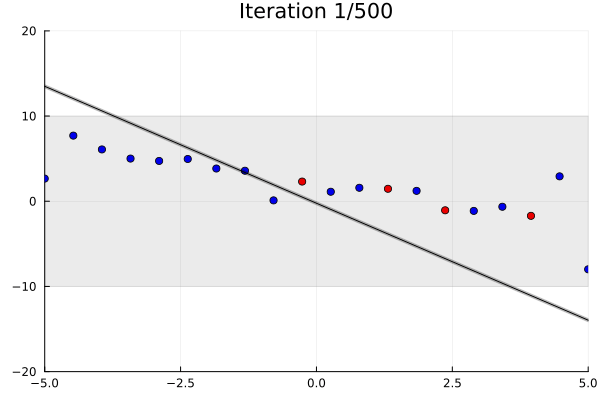

In [21]:
t, = generate(regression_with_outliers, (xs,), observations)

viz = Plots.@animate for i in 1:500
    global t
    t = block_resimulation_update(t)
    visualize_trace(t; title="Iteration $i/500")
end;
gif(viz)

We can see that although the algorithm keeps changing the inferences of which points are inliers and outliers, 
it has a harder time refining the continuous parameters. We address this challenge next.

## 5. MCMC Inference Part 2: Gaussian Drift MH  <a name="mcmc-2"></a>

So far, we've seen one form of incremental trace update:

```julia
(tr, did_accept) = mh(tr, select(:address1, :address2, ...))
```

This update is incremental in that it only proposes changes to part of a
trace (the selected addresses). But when computing _what_ changes to propose,
it ignores the current state completely and resimulates all-new values from
the model.

That wholesale resimulation of values is often not the best way to search for
improvements. To that end, Gen also offers a more general flavor of MH:

```julia
(tr, did_accept) = mh(tr, custom_proposal, custom_proposal_args)
```

A "custom proposal" is just what it sounds like: whereas before, we were
using the _default resimulation proposal_ to come up with new values for the
selected addresses, we can now pass in a generative function that samples
proposed values however it wants.

For example, here is a custom proposal that takes in a current trace, and
proposes a new slope and intercept by randomly perturbing the existing
values:

In [22]:
@gen function line_proposal(current_trace)
    slope ~ normal(current_trace[:slope], 0.5)
    intercept ~ normal(current_trace[:intercept], 0.5)
end;

This is often called a "Gaussian drift" proposal, because it essentially amounts to proposing steps of a random walk. (What makes it different from a random walk is that we will still use an MH accept/reject step to make sure we don't wander into areas of very low probability.)

To use the proposal, we write:

```julia
(tr, did_accept) = mh(tr, line_proposal, ())
```

Two things to note:

1. We no longer need to pass a selection of addresses. Instead, Gen assumes
   that whichever addresses are sampled by the proposal (in this case,
   `:slope` and `:intercept`) are being proposed to.

2. The argument list to the proposal is an empty tuple, `()`. The
   `line_proposal` generative function does expect an argument, the previous
   trace, but this is supplied automatically to all MH custom proposals
   (a proposal generative function for use with `mh` must take as its first argument the 
   current trace of the model).

Let's swap it into our update:

In [23]:
function gaussian_drift_update(tr)
    # Gaussian drift on line params
    (tr, _) = mh(tr, line_proposal, ())
    
    # Block resimulation: Update the outlier classifications
    (xs,) = get_args(tr)
    n = length(xs)
    for i=1:n
        (tr, _) = mh(tr, select(:data => i => :is_outlier))
    end
    
    # Block resimulation: Update the prob_outlier parameter
    (tr, w) = mh(tr, select(:prob_outlier))
    (tr, w) = mh(tr, select(:noise))
    tr
end;

If we compare the Gaussian Drift proposal visually with our old algorithm, we
can see the new behavior:

Plots.AnimatedGif("/Users/derrickxiong/Documents/MIT/Fall 2022/9.66/project/gen-quickstart/tutorials/tmp.gif")
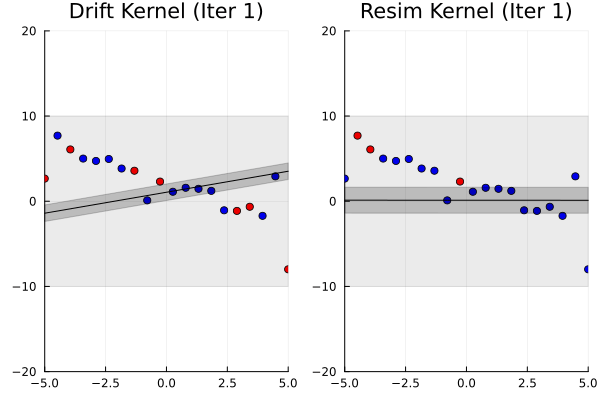

In [24]:
tr1, = generate(regression_with_outliers, (xs,), observations)
tr2 = tr1

viz = Plots.@animate for i in 1:300
    global tr1, tr2
    tr1 = gaussian_drift_update(tr1)
    tr2 = block_resimulation_update(tr2)
    Plots.plot(visualize_trace(tr1; title="Drift Kernel (Iter $i)"), 
               visualize_trace(tr2; title="Resim Kernel (Iter $i)"))
end;
gif(viz)

-----------

### Exercise: Analyzing the algorithms

Run the cell above several times. Compare the two
algorithms with respect to the following:

- How fast do they find a relatively good line?

- Does one of them tend to get stuck more than the other? Under what
  conditions? Why?

The drift kernel is much faster at finding a good line. This makes sense, as using drift instead of random guesses makes the model more likely to find improvements faster.

The resim kernel gets stuck for longer periods of time. This is because when it finds a reasonably good line and inferred noise, it takes a long time for it to find a better classification scheme. While the drift can also get stuck, it will mostly get stuck in local minima due to bad choices of the amount of noise in the Gaussian distributions used.

-----------

A more quantitative comparison demonstrates that our change has
improved our inference quality:

In [15]:
function gaussian_drift_inference(xs, observations)
    (tr, _) = generate(regression_with_outliers, (xs,), observations)
    for iter=1:500
        tr = gaussian_drift_update(tr)
    end
    tr
end

scores = Vector{Float64}(undef, 10)
for i=1:10
    @time tr = gaussian_drift_inference(xs, observations)
    scores[i] = get_score(tr)
end
println("Log probability: ", logmeanexp(scores))

  0.945679 seconds (12.66 M allocations: 742.869 MiB, 11.25% gc time, 36.08% compilation time)
  0.594651 seconds (11.70 M allocations: 690.177 MiB, 15.40% gc time)
  0.568201 seconds (11.70 M allocations: 690.177 MiB, 13.87% gc time)
  0.598925 seconds (11.70 M allocations: 690.177 MiB, 15.30% gc time)
  0.578850 seconds (11.70 M allocations: 690.177 MiB, 14.97% gc time)
  0.578489 seconds (11.70 M allocations: 690.177 MiB, 13.90% gc time)
  0.563690 seconds (11.70 M allocations: 690.177 MiB, 14.90% gc time)
  0.588094 seconds (11.70 M allocations: 690.177 MiB, 15.10% gc time)
  0.593818 seconds (11.70 M allocations: 690.177 MiB, 15.10% gc time)
  0.586240 seconds (11.70 M allocations: 690.177 MiB, 14.26% gc time)
Log probability: -43.47702817168526


## 6. MCMC Inference Part 3: Heuristics to guide the process  <a name="mcmc-3"></a>

In this section, we'll look at another strategy for improving MCMC inference:
using arbitrary heuristics to make smarter proposals. In particular, we'll
use a method called "Random Sample Consensus" (or RANSAC) to quickly find
promising settings of the slope and intercept parameters.

RANSAC works as follows:
1. We repeatedly choose a small random subset of the points, say, of size 3.
2. We do least-squares linear regression to find a line of best fit for those
   points.
3. We count how many points (from the entire set) are near the line we found.
4. After a suitable number of iterations (say, 10), we return the line that
   had the highest score.

Here's our implementation of the algorithm in Julia:

In [25]:
import StatsBase

struct RANSACParams
    """the number of random subsets to try"""
    iters::Int

    """the number of points to use to construct a hypothesis"""
    subset_size::Int

    """the error threshold below which a datum is considered an inlier"""
    eps::Float64
    
    function RANSACParams(iters, subset_size, eps)
        if iters < 1
            error("iters < 1")
        end
        new(iters, subset_size, eps)
    end
end


function ransac(xs::Vector{Float64}, ys::Vector{Float64}, params::RANSACParams)
    best_num_inliers::Int = -1
    best_slope::Float64 = NaN
    best_intercept::Float64 = NaN
    for i=1:params.iters
        # select a random subset of points
        rand_ind = StatsBase.sample(1:length(xs), params.subset_size, replace=false)
        subset_xs = xs[rand_ind]
        subset_ys = ys[rand_ind]
        
        # estimate slope and intercept using least squares
        A = hcat(subset_xs, ones(length(subset_xs)))
        slope, intercept = A \ subset_ys # use backslash operator for least sq soln
        
        ypred = intercept .+ slope * xs

        # count the number of inliers for this (slope, intercept) hypothesis
        inliers = abs.(ys - ypred) .< params.eps
        num_inliers = sum(inliers)

        if num_inliers > best_num_inliers
            best_slope, best_intercept = slope, intercept
            best_num_inliers = num_inliers
        end
    end

    # return the hypothesis that resulted in the most inliers
    (best_slope, best_intercept)
end;

We can now wrap it in a Gen proposal that calls out to RANSAC, then samples a
slope and intercept near the one it proposed.

In [26]:
@gen function ransac_proposal(prev_trace, xs, ys)
    (slope_guess, intercept_guess) = ransac(xs, ys, RANSACParams(10, 3, 1.))
    slope ~ normal(slope_guess, 0.1)
    intercept ~ normal(intercept_guess, 1.0)
end;

(Notice that although `ransac` makes random choices, they are not addressed
(and they happen outside of a Gen generative function), so Gen cannot reason
about them. This is OK (see [1]). Writing proposals that have
traced internal randomness (i.e., that make traced random choices that are
not directly used in the proposal) can lead to better inference, but requires
the use of a more complex version of Gen's `mh` operator, which is beyond the
scope of this tutorial.)

[1] [Using probabilistic programs as
proposals](https://arxiv.org/abs/1801.03612), Marco F. Cusumano-Towner, Vikash K. Mansinghka, 2018.

One iteration of our update algorithm will now look like this:

In [27]:
function ransac_update(tr)
    # Use RANSAC to (potentially) jump to a better line
    # from wherever we are
    (tr, _) = mh(tr, ransac_proposal, (xs, ys))
    
    # Spend a while refining the parameters, using Gaussian drift
    # to tune the slope and intercept, and resimulation for the noise
    # and outliers.
    for j=1:20
        (tr, _) = mh(tr, select(:prob_outlier))
        (tr, _) = mh(tr, select(:noise))
        (tr, _) = mh(tr, line_proposal, ())
        # Reclassify outliers
        for i=1:length(get_args(tr)[1])
            (tr, _) = mh(tr, select(:data => i => :is_outlier))
        end
    end
    tr
end

ransac_update (generic function with 1 method)

We can now run our main loop for just 5 iterations, and achieve pretty good
results. (Of course, since we do 20 inner loop iterations in `ransac_update`,
this is really closer to 100 iterations.) The running time is significantly
less than before, without a real dip in quality:

In [32]:
function ransac_inference(xs, ys, observations)
    (slope, intercept) = ransac(xs, ys, RANSACParams(10, 3, 1.))
    slope_intercept_init = choicemap()
    slope_intercept_init[:slope] = slope
    slope_intercept_init[:intercept] = intercept
    (tr, _) = generate(regression_with_outliers, (xs,), merge(observations, slope_intercept_init))
    for iter=1:5
        tr = ransac_update(tr)
    end
    tr
end

scores = Vector{Float64}(undef, 10)
for i=1:10
    @time tr = ransac_inference(xs, ys, observations)
    scores[i] = get_score(tr)
end
println("Log probability: ", logmeanexp(scores))

  0.210567 seconds (2.38 M allocations: 147.141 MiB, 7.27% gc time, 3.42% compilation time)
  0.189920 seconds (2.36 M allocations: 146.217 MiB, 4.33% gc time)
  0.195694 seconds (2.36 M allocations: 146.217 MiB, 7.99% gc time)
  0.185373 seconds (2.36 M allocations: 146.217 MiB, 4.19% gc time)
  0.192549 seconds (2.36 M allocations: 146.217 MiB, 8.16% gc time)
  0.192834 seconds (2.36 M allocations: 146.217 MiB, 7.81% gc time)
  0.188912 seconds (2.36 M allocations: 146.217 MiB, 4.08% gc time)
  0.194328 seconds (2.36 M allocations: 146.217 MiB, 8.01% gc time)
  0.193828 seconds (2.36 M allocations: 146.217 MiB, 7.97% gc time)
  0.185225 seconds (2.36 M allocations: 146.217 MiB, 4.15% gc time)
Log probability: -43.239126492844214


Let's visualize the algorithm:

Plots.AnimatedGif("/Users/derrickxiong/Documents/MIT/Fall 2022/9.66/project/gen-quickstart/tutorials/tmp.gif")
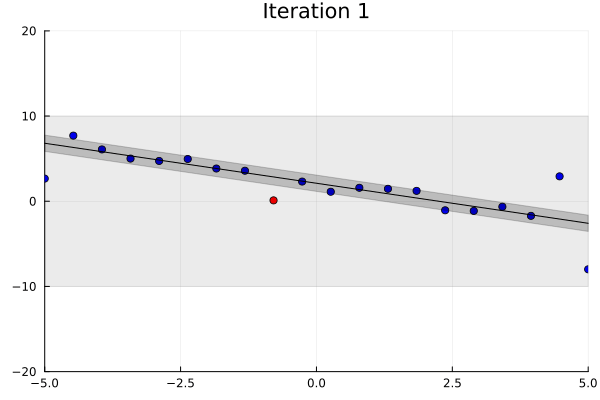

In [29]:
(slope, intercept) = ransac(xs, ys, RANSACParams(10, 3, 1.))
slope_intercept_init = choicemap()
slope_intercept_init[:slope] = slope
slope_intercept_init[:intercept] = intercept
(tr, _) = generate(regression_with_outliers, (xs,), merge(observations, slope_intercept_init))

viz = Plots.@animate for i in 1:100
    global tr

    if i % 20 == 0
        (tr, _) = mh(tr, ransac_proposal, (xs, ys))
    end

    # Spend a while refining the parameters, using Gaussian drift
    # to tune the slope and intercept, and resimulation for the noise
    # and outliers.
    (tr, _) = mh(tr, select(:prob_outlier))
    (tr, _) = mh(tr, select(:noise))
    (tr, _) = mh(tr, line_proposal, ())
    
    # Reclassify outliers
    for i=1:length(get_args(tr)[1])
        (tr, _) = mh(tr, select(:data => i => :is_outlier))
    end

    visualize_trace(tr; title="Iteration $i")
end;

gif(viz)

-----------
### Exercise
#### Improving the heuristic
Currently, the RANSAC heuristic does not use the current trace's information
at all. Try changing it to use the current state as follows:
Instead of a constant `eps` parameter that controls whether a point is
considered an inlier, make this decision based on the currently hypothesized
noise level.  Specifically, set `eps` to be equal to the `noise` parameter of the trace.

Examine whether this improves inference (no need to respond in words here).

In [36]:
# Modify the function below (which currently is just a copy of `ransac_proposal`) 
# as described above so that implements a RANSAC proposal with inlier 
# status decided by the noise parameter of the previous trace
# (do not modify the return value, which is unneccessary for a proposal, 
# but used for testing)

# This doesn't really improve the model at all; while it might make it marginally faster at finding

@gen function ransac_proposal_noise_based(prev_trace, xs, ys)
    params = RANSACParams(10, 3, prev_trace[:noise])
    (slope_guess, intercept_guess) = ransac(xs, ys, params)
    slope ~ normal(slope_guess, 0.1)
    intercept ~ normal(intercept_guess, 1.0)
    return params, slope, intercept # (return values just for testing)
end;

<!-- # BEGIN ANSWER KEY
@gen function ransac_proposal_noise_based(prev_trace, xs, ys)
    eps = prev_trace[:noise]
    params = RANSACParams(10, 3, eps)
    (slope_guess, intercept_guess) = ransac(xs, ys, params)
    slope ~ normal(slope_guess, 0.1)
    intercept ~ normal(intercept_guess, 1.0)
    return params, slope, intercept # (return values just for testing)
end;
# END ANSWER KEY -->
<hr>

The code below runs the RANSAC inference as above, but using `ransac_proposal_noise_based`.

In [38]:
function ransac_update_noise_based(tr)
    # Use RANSAC to (potentially) jump to a better line
    (tr, _) = mh(tr, ransac_proposal_noise_based, (xs, ys))
    # Refining the parameters
    for j=1:20
        (tr, _) = mh(tr, select(:prob_outlier))
        (tr, _) = mh(tr, select(:noise))
        (tr, _) = mh(tr, line_proposal, ())
        # Reclassify outliers
        for i=1:length(get_args(tr)[1])
            (tr, _) = mh(tr, select(:data => i => :is_outlier))
        end
    end
    tr
end;
function ransac_inference_noise_based(xs, ys, observations)
    # Use an initial epsilon value of 1.
    (slope, intercept) = ransac(xs, ys, RANSACParams(10, 3, 1.))
    slope_intercept_init = choicemap()
    slope_intercept_init[:slope] = slope
    slope_intercept_init[:intercept] = intercept
    (tr, _) = generate(regression_with_outliers, (xs,), merge(observations, slope_intercept_init))
    for iter=1:5
        tr = ransac_update_noise_based(tr)
    end
    tr
end

scores = Vector{Float64}(undef, 10)
for i=1:10
    @time tr = ransac_inference_noise_based(xs, ys, observations)
    scores[i] = get_score(tr)
end
println("Log probability: ", logmeanexp(scores))

  0.323682 seconds (2.42 M allocations: 149.537 MiB, 22.50% gc time, 11.39% compilation time)
  0.189878 seconds (2.36 M allocations: 146.218 MiB, 4.13% gc time)
  0.193624 seconds (2.36 M allocations: 146.218 MiB, 7.94% gc time)
  0.186790 seconds (2.36 M allocations: 146.218 MiB, 4.27% gc time)
  0.198179 seconds (2.36 M allocations: 146.218 MiB, 8.33% gc time)
  0.193844 seconds (2.36 M allocations: 146.218 MiB, 8.01% gc time)
  0.185777 seconds (2.36 M allocations: 146.218 MiB, 4.22% gc time)
  0.197084 seconds (2.36 M allocations: 146.218 MiB, 8.08% gc time)
  0.185722 seconds (2.36 M allocations: 146.218 MiB, 4.22% gc time)
  0.196231 seconds (2.36 M allocations: 146.218 MiB, 8.16% gc time)
Log probability: -43.31479388455676


-----------

### Exercise
Implement a heuristic-based proposal that selects the points that are
currently classified as *inliers*, finds the line of best fit for this 
subset of points, and adds some noise.

_Hint_: you can get the result for linear regression using least squares approximation by
solving a linear system using Julia's [backslash operator, `\`](https://docs.julialang.org/en/v1/base/math/#Base.:\\-Tuple{Any,Any}) (as is done in the `ransac`
function, above).  See also a [simple demonstration here](linear-regression-demo.jl).

We provide some starter code. You can test your solution by modifying the plotting code above.

In [39]:
@gen function inlier_heuristic_proposal(prev_trace, xs, ys)
    # Put your code below, ensure that you compute values for
    # inlier_slope, inlier_intercept and delete the two placeholders
    # below.
    
    ypred = prev_trace[:intercept] .+ prev_trace[:slope] * xs

    inlier_filter = abs.(ys - ypred) .< prev_trace[:noise]
    subset_xs = xs[inlier_filter]
    subset_ys = ys[inlier_filter]
    
    A = hcat(subset_xs, ones(length(subset_xs)))
     
    inlier_slope, inlier_intercept = A \ subset_ys
    
    
    # Make a noisy proposal.
    slope     ~ normal(inlier_slope, 0.5)
    intercept ~ normal(inlier_intercept, 0.5)
    # We return values here for testing; normally, proposals don't have to return values.
    return inlier_slope, inlier_intercept
end;

function inlier_heuristic_update(tr)
    # Use inlier heuristics to (potentially) jump to a better line
    # from wherever we are.
    (tr, _) = mh(tr, inlier_heuristic_proposal, (xs, ys))    
    # Spend a while refining the parameters, using Gaussian drift
    # to tune the slope and intercept, and resimulation for the noise
    # and outliers.
    for j=1:20
        (tr, _) = mh(tr, select(:prob_outlier))
        (tr, _) = mh(tr, select(:noise))
        (tr, _) = mh(tr, line_proposal, ())
        # Reclassify outliers
        for i=1:length(get_args(tr)[1])
            (tr, _) = mh(tr, select(:data => i => :is_outlier))
        end
    end
    tr
end

inlier_heuristic_update (generic function with 1 method)

Plots.AnimatedGif("/Users/derrickxiong/Documents/MIT/Fall 2022/9.66/project/gen-quickstart/tutorials/tmp.gif")
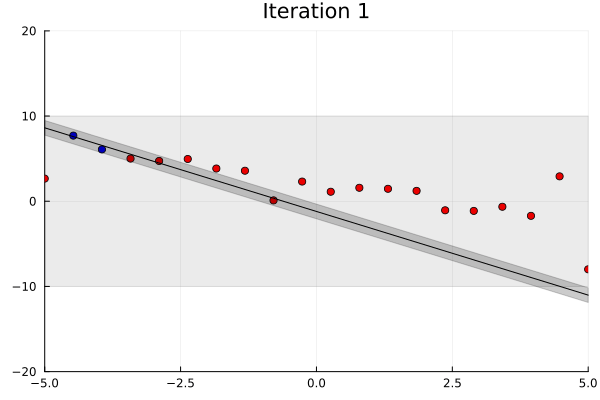

In [42]:
tr, = Gen.generate(regression_with_outliers, (xs,), observations)
viz = @animate for i in 1:50
    global tr
    tr = inlier_heuristic_update(tr)
    visualize_trace(tr; title="Iteration $i")
end
gif(viz)

<!-- # BEGIN ANSWER KEY 2B.2

@gen function inlier_heuristic_proposal(prev_trace, xs, ys)
    # get_indeces for inliers.
    inlier_indeces = filter(
        i -> !prev_trace[:data => i => :is_outlier], 
        1:length(xs)
    )
    xs_inlier = xs[inlier_indeces]
    ys_inlier = ys[inlier_indeces]
    # estimate slope and intercept using least squares.
    A = hcat(xs_inlier, ones(length(xs_inlier)))
    inlier_slope, inlier_intercept = A \ ys_inlier
    
    # Make a noisy proposal.
    slope     ~ normal(inlier_slope, 0.5)
    intercept ~ normal(inlier_intercept, 0.5)
    # We return values here for testing; normally, proposals don't have to return values.
    return inlier_slope, inlier_intercept
end;

function inlier_heuristic_update(tr)
    # Use inlier heuristics to (potentially) jump to a better line
    # from wherever we are.
    (tr, _) = mh(tr, inlier_heuristic_proposal, (xs, ys))    
    # Spend a while refining the parameters, using Gaussian drift
    # to tune the slope and intercept, and resimulation for the noise
    # and outliers.
    for j=1:20
        (tr, _) = mh(tr, select(:prob_outlier))
        (tr, _) = mh(tr, select(:noise))
        (tr, _) = mh(tr, line_proposal, ())
        # Reclassify outliers
        for i=1:length(get_args(tr)[1])
            (tr, _) = mh(tr, select(:data => i => :is_outlier))
        end
    end
    tr
end;

# END ANSWER KEY -->
----

### Exercise: Initialization

In our inference program above, when generating an initial trace on which to
iterate, we initialize the slope and intercept to values proposed by RANSAC.
If we don't do this, the performance decreases sharply, despite the fact that
we still propose new slope/intercept pairs from RANSAC once the loop starts.
Why is this?

This is because our proposals are extremely unlikely if we choose the wrong initialization, as we are proposing a large drift relative to the starting conditions. Thus, by first making sure our initial parameters are within the correct ballpark we avoid having to take that first large step towards the set of "good" RANSAC proposals.

----

## 7. MAP Optimization  <a name="map"></a>

Everything we've done so far has been within the MCMC framework. But
sometimes you're not interested in getting posterior samples—sometimes you
just want a single likely explanation for your data. Gen also provides tools
for _maximum a posteriori_ estimation ("MAP estimation"), the problem of
finding a trace that maximizes the posterior probability under the model
given observations.

For example, let's say we wanted to take a trace and assign each point's
`is_outlier` score to the most likely possibility. We can do this by
iterating over both possible traces, scoring them, and choosing the one with
the higher score. We can do this using Gen's
[`update`](https://probcomp.github.io/Gen/dev/ref/gfi/#Update-1) function,
which allows us to manually update a trace to satisfy some constraints:

In [43]:
function is_outlier_map_update(tr)
    (xs,) = get_args(tr)
    for i=1:length(xs)
        constraints = choicemap(:prob_outlier => 0.1)
        constraints[:data => i => :is_outlier] = false
        (trace1,) = update(tr, (xs,), (NoChange(),), constraints)
        constraints[:data => i => :is_outlier] = true
        (trace2,) = update(tr, (xs,), (NoChange(),), constraints)
        tr = (get_score(trace1) > get_score(trace2)) ? trace1 : trace2
    end
    tr
end;

For continuous parameters, we can use Gen's `map_optimize` function, which uses _automatic differentiation_ to shift the selected parameters in the direction that causes the probability of the trace to increase most sharply:

```julia
tr = map_optimize(tr, select(:slope, :intercept), max_step_size=1., min_step_size=1e-5)
```

Putting these updates together, we can write an inference program that uses our RANSAC algorithm from above to get an initial trace, then tunes it using optimization:

Score after ransac: -45.34710859168629. Final score: -41.01265557169515.


Plots.AnimatedGif("/Users/derrickxiong/Documents/MIT/Fall 2022/9.66/project/gen-quickstart/tutorials/tmp.gif")
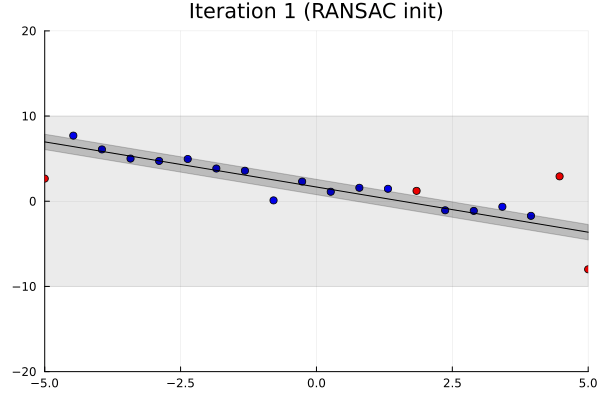

In [44]:
using StatsBase: mean

(slope, intercept) = ransac(xs, ys, RANSACParams(10, 3, 1.))
slope_intercept_init = choicemap()
slope_intercept_init[:slope] = slope
slope_intercept_init[:intercept] = intercept
(tr,) = generate(regression_with_outliers, (xs,), merge(observations, slope_intercept_init))


ransac_score, final_score = 0, 0
viz = Plots.@animate for i in 1:35
    global tr, ransac_score
    if i < 6
        tr = ransac_update(tr)
    else
        tr = map_optimize(tr, select(:slope, :intercept), max_step_size=1., min_step_size=1e-5)
        tr = map_optimize(tr, select(:noise), max_step_size=1e-2, min_step_size=1e-5)
        tr = is_outlier_map_update(tr)
        optimal_prob_outlier = mean([tr[:data => i => :is_outlier] for i in 1:length(xs)])
        optimal_prob_outlier = min(0.5, max(0.05, optimal_prob_outlier))
        tr, = update(tr, (xs,), (NoChange(),), choicemap(:prob_outlier => optimal_prob_outlier))
    end
    
    if i == 5
        ransac_score = get_score(tr)
    end
    
    visualize_trace(tr; title="Iteration $i $(i < 6 ? "(RANSAC init)" : "(MAP optimization)")")
end
final_score = get_score(tr)

println("Score after ransac: $(ransac_score). Final score: $(final_score).")
gif(viz)

Below, we evaluate the algorithm and we see that it gets our best scores yet, which is what it's meant to do:

In [45]:
function map_inference(xs, ys, observations)
    (slope, intercept) = ransac(xs, ys, RANSACParams(10, 3, 1.))
    slope_intercept_init = choicemap()
    slope_intercept_init[:slope] = slope
    slope_intercept_init[:intercept] = intercept
    (tr, _) = generate(regression_with_outliers, (xs,), merge(observations, slope_intercept_init))
    for iter=1:5
        tr = ransac_update(tr)
    end
    
    for iter = 1:20
        # Take a single gradient step on the line parameters.
        tr = map_optimize(tr, select(:slope, :intercept), max_step_size=1., min_step_size=1e-5)
        tr = map_optimize(tr, select(:noise), max_step_size=1e-2, min_step_size=1e-5)
        
        # Choose the most likely classification of outliers.
        tr = is_outlier_map_update(tr)
        
        # Update the prob outlier
        choices = get_choices(tr)
        optimal_prob_outlier = count(i -> choices[:data => i => :is_outlier], 1:length(xs)) / length(xs)
        optimal_prob_outlier = min(0.5, max(0.05, optimal_prob_outlier))
        (tr, _) = update(tr, (xs,), (NoChange(),), choicemap(:prob_outlier => optimal_prob_outlier))        
    end
    tr
end

scores = Vector{Float64}(undef, 10)
for i=1:10
    @time tr = map_inference(xs,ys,observations)
    scores[i] = get_score(tr)
end
println(logmeanexp(scores))

  0.402265 seconds (4.60 M allocations: 267.851 MiB, 7.95% gc time, 20.18% compilation time)
  0.321088 seconds (4.22 M allocations: 246.968 MiB, 8.17% gc time)
  0.319473 seconds (4.23 M allocations: 247.453 MiB, 7.60% gc time)
  0.309897 seconds (4.23 M allocations: 247.356 MiB, 5.14% gc time)
  0.322332 seconds (4.22 M allocations: 247.258 MiB, 7.46% gc time)
  0.319313 seconds (4.23 M allocations: 247.453 MiB, 7.51% gc time)
  0.311349 seconds (4.23 M allocations: 247.356 MiB, 5.14% gc time)
  0.317512 seconds (4.23 M allocations: 247.453 MiB, 7.60% gc time)
  0.312198 seconds (4.13 M allocations: 242.056 MiB, 7.58% gc time)
  0.309148 seconds (4.22 M allocations: 247.161 MiB, 5.05% gc time)
-41.11794967281579


This doesn't necessarily mean that it's "better," though. It finds the most
probable explanation of the data, which is a different problem from the one
we tackled with MCMC inference. There, the goal was to sample from the
posterior, which allows us to better characterize our uncertainty. Using
MCMC, there might be a borderline point that is sometimes classified as an
outlier and sometimes not, reflecting our uncertainty; with MAP optimization,
we will always be shown the most probable answer.

---------

Below we generate a dataset for which there are two distinct possible explanations
(the grey lines) under our model `regression_with_outliers`. 

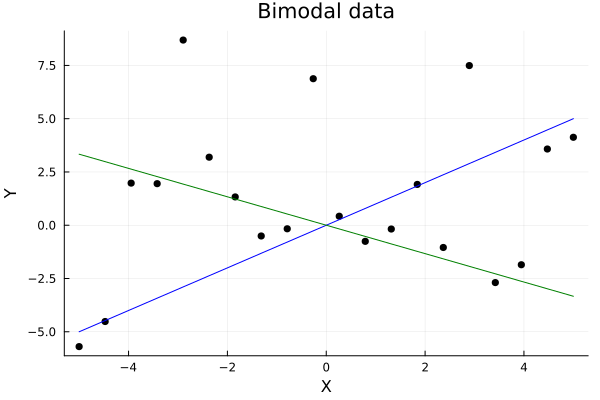

In [46]:
function make_bimodal_dataset(n)
    Random.seed!(4) 
    prob_outlier = 0.2
    true_inlier_noise = 0.5
    true_outlier_noise = 5.0
    true_slope1 = 1
    true_intercept1 = 0
    true_slope2 = -2/3
    true_intercept2 = 0
    xs = collect(range(-5, stop=5, length=n))
    ys = Float64[]
    for (i, x) in enumerate(xs)
        if rand() < prob_outlier
            y = randn() * true_outlier_noise
        else
            if rand((true,false))
                y = true_slope1 * x + true_intercept1 + randn() * true_inlier_noise
            else
                y = true_slope2 * x + true_intercept2 + randn() * true_inlier_noise
            end
        end
        push!(ys, y)
    end
    xs,ys,true_slope1,true_slope2,true_intercept1,true_intercept2
end;

(xs, ys_bimodal, m1,m2,b1,b2) = make_bimodal_dataset(20);
observations_bimodal = make_constraints(ys_bimodal);

Plots.scatter(xs, ys_bimodal, color="black", xlabel="X", ylabel="Y", label=nothing, title="Bimodal data")
Plots.plot!(xs,m1.*xs.+b1, color="blue", label=nothing)
Plots.plot!(xs,m2.*xs.+b2, color="green", label=nothing)

### Exercise

For this dataset, the code below will run (i) Metropolis hastings with a
Gaussian Drift proposal and (ii) MAP optimization, using implementations from
above. Make sure you understand what it is doing. Do both algorithms explore
both modes (i.e. both possible explanations)?  Play with running the
algorithms multiple times.  

If one or both algorithms doesn't then explain in a few sentences why you
think this is.


No; the MAP algorithm stays at the slightly more likely mode. This is because the drift proposal schema allows for some probability of moving to the other mode, even though it is a big jump. However, the MAP optimization will always go straight for the local minima (or global minima, depending on how the map_optimize function is implemented), and therefore not explore both modes.

i.   MH Gaussian drift score -67.90298781592773
ii.  MAP final score: -41.012655584900045.


Plots.AnimatedGif("/Users/alexlew/gen-quickstart/tutorials/tmp.gif")
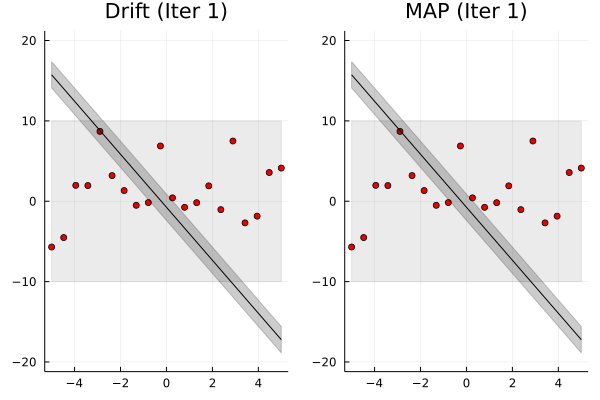

In [51]:
(slope, intercept) = ransac(xs, ys_bimodal, RANSACParams(10, 3, 1.))
slope_intercept_init = choicemap()
slope_intercept_init[:slope] = slope
slope_intercept_init[:intercept] = intercept
(tr,) = generate(
    regression_with_outliers, (xs,), 
    merge(observations_bimodal, slope_intercept_init))

tr_drift = tr
tr_map   = tr

viz = Plots.@animate for i in 1:305
    global tr_map, tr_drift
    if i < 6
        tr_drift = ransac_update(tr)
        tr_map   = tr_drift
    else
        # Take a single gradient step on the line parameters.
        tr_map = map_optimize(tr_map, select(:slope, :intercept), max_step_size=1., min_step_size=1e-5)
        tr_map = map_optimize(tr_map, select(:noise), max_step_size=1e-2, min_step_size=1e-5)
        # Choose the most likely classification of outliers.
        tr_map = is_outlier_map_update(tr_map)
        # Update the prob outlier
        optimal_prob_outlier = mean([tr_map[:data => i => :is_outlier] for i in 1:length(xs)])
        optimal_prob_outlier = min(0.5, max(0.05, optimal_prob_outlier))
        tr_map, = update(tr_map, (xs,), (NoChange(),), choicemap(:prob_outlier => optimal_prob_outlier))
    
        # Gaussian drift update:
        tr_drift = gaussian_drift_update(tr_drift)
    end
    
    Plots.plot(visualize_trace(tr_drift; title="Drift (Iter $i)"), visualize_trace(tr_map; title="MAP (Iter $i)"))
end

drift_final_score = get_score(tr_drift)
map_final_score = get_score(tr_map)
println("i.   MH Gaussian drift score $(drift_final_score)")
println("ii.  MAP final score: $(final_score).")

gif(viz)

The above was good for an overall qualitative examination, but let's also 
examine a little more quantitatively how often the two proposals explore
the two modes, by running multiple times and keeping track of how often the
slope is positive/negative for each, for a few different initializations.

**Warning: the following cell may take a few minutes to run.**

In [49]:
total_runs = 25;

In [47]:
for (index, value) in enumerate([(1, 0), (-1, 0), ransac(xs, ys_bimodal, RANSACParams(10, 3, 1.))])
    n_pos_drift = n_neg_drift = n_pos_map = n_neg_map = 0
    
    for i=1:total_runs
        pos_drift = neg_drift = pos_map = neg_map = false

        #### RANSAC for initializing
        (slope, intercept) = value # ransac(xs, ys_bimodal, RANSACParams(10, 3, 1.))
        slope_intercept_init = choicemap()
        slope_intercept_init[:slope] = slope
        slope_intercept_init[:intercept] = intercept
        (tr,) = generate(
            regression_with_outliers, (xs,), 
            merge(observations_bimodal, slope_intercept_init))
        for iter=1:5
            tr = ransac_update(tr)
        end
        ransac_score = get_score(tr)
        tr_drift = tr # version of the trace for the Gaussian drift algorithm
        tr_map = tr   # version of the trace for the MAP optimization

        #### Refine the parameters according to each of the algorithms
        for iter = 1:300
            # MAP optimiztion:
            # Take a single gradient step on the line parameters.
            tr_map = map_optimize(tr_map, select(:slope, :intercept), max_step_size=1., min_step_size=1e-5)
            tr_map = map_optimize(tr_map, select(:noise), max_step_size=1e-2, min_step_size=1e-5)
            # Choose the most likely classification of outliers.
            tr_map = is_outlier_map_update(tr_map)
            # Update the prob outlier
            optimal_prob_outlier = count(i -> tr_map[:data => i => :is_outlier], 1:length(xs)) / length(xs)
            optimal_prob_outlier = min(0.5, max(0.05, optimal_prob_outlier))
            (tr_map, _) = update(tr_map, (xs,), (NoChange(),), choicemap(:prob_outlier => optimal_prob_outlier))

            # Gaussian drift update:
            tr_drift = gaussian_drift_update(tr_drift)

            if tr_drift[:slope] > 0
                pos_drift = true
            elseif tr_drift[:slope] < 0
                neg_drift = true
            end
            if tr_map[:slope] > 0
                pos_map = true  
            elseif tr_map[:slope] < 0
                neg_map = true
            end
        end

        if pos_drift
            n_pos_drift += 1
        end
        if neg_drift
            n_neg_drift += 1
        end
        if pos_map
            n_pos_map += 1
        end
        if neg_map
            n_neg_map += 1
        end
    end
    (slope, intercept) = value
    println("\n\nWITH INITIAL SLOPE $(slope) AND INTERCEPT $(intercept)")
    println("TOTAL RUNS EACH: $(total_runs)")
    println("\n       times neg. slope    times pos. slope")
    println("\ndrift: $(n_neg_drift)                  $(n_pos_drift)")
    println("\nMAP:   $(n_neg_map)                    $(n_pos_map)")
end

LoadError: UndefVarError: total_runs not defined

Although this experiment is imperfect, we can broadly see that the drift kernel often explores both modes within a single run, whereas this is rarer for the MAP kernel (in 25 runs, the MAP kernel visits on average 1.08 of the 2 modes, whereas the drift kernel visits 1.6).